In [1]:
import numpy as np
import os
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from scipy.io import loadmat

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print (DEVICE)

cuda


In [2]:
# Global Variables
BATCH_SIZE = 64
LEARNING_RATE = 0.001
N_EPOCHS = 60
RANDOM_SEED = 32

N_CLASSES = 200

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='green', label='Training loss') 
    ax.plot(valid_losses, color='orange', label='Testing loss')
    ax.set(title="Loss across epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('ggplot')

def train_optm (train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop_optm (model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_optm (train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)}     '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.3f}\t'
                  f'Test loss: {valid_loss:.3f}\t'
                  f'Train accuracy: {100 * train_acc:.3f}\t'
                  f'Test accuracy: {100 * valid_acc:.3f}')
            
    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)


In [9]:
# Path to train, test and val data
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "drive/MyDrive/SVHN"
test_dir = os.path.join(here, subdir, "test")
train_dir = os.path.join(here, subdir, "train")
val_dir = os.path.join(here, subdir, "val")

# Transform images into 32 pixels x 32 pixels as reqd by LeNet-5
mean = (0.44808328)
stddev = (0.22610814)
my_trans_svhn = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean, stddev)])

# Make dataset objects
train_data_svhn = datasets.SVHN (train_dir, split = 'train', transform = my_trans_svhn, download = True)
test_data_svhn = datasets.SVHN (test_dir, split = 'test', transform = my_trans_svhn, download = True)
train_load_svhn = DataLoader (dataset=train_data_svhn, batch_size=BATCH_SIZE, shuffle=True)
test_load_svhn = DataLoader (dataset=test_data_svhn, batch_size=BATCH_SIZE, shuffle=True)

print (len(train_data_svhn[0][0]))

1


In [10]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

09:23:40     Epoch: 9	Train loss: 2.245	Test loss: 2.229	Train accuracy: 18.921	Test accuracy: 19.587
09:28:11     Epoch: 19	Train loss: 2.244	Test loss: 2.233	Train accuracy: 18.887	Test accuracy: 19.445
09:32:32     Epoch: 29	Train loss: 2.244	Test loss: 2.233	Train accuracy: 18.921	Test accuracy: 19.587
09:36:49     Epoch: 39	Train loss: 2.244	Test loss: 2.236	Train accuracy: 18.921	Test accuracy: 19.587
09:41:04     Epoch: 49	Train loss: 2.244	Test loss: 2.231	Train accuracy: 18.921	Test accuracy: 19.587
09:45:24     Epoch: 59	Train loss: 2.244	Test loss: 2.232	Train accuracy: 18.921	Test accuracy: 19.587


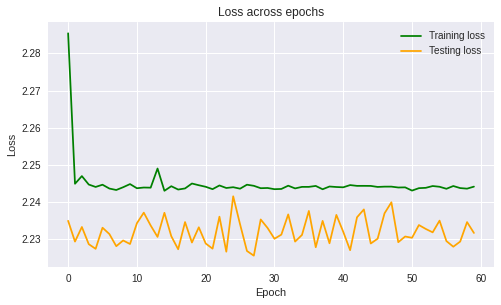

In [12]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop_optm (model, criterion, optimizer, train_load_svhn, test_load_svhn, N_EPOCHS, DEVICE, print_every = 10)